### Simple Data Loading

In [4]:
# Importing Libraries
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import os

# This is the needed transformation for the pretrained model
our_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 32

dataset = datasets.ImageFolder('../Data/Prostate Cancer',transform= our_transform)

# Splitting Data (70% Train, 30% Test)
train_set,test_set=th.utils.data.random_split(dataset,[0.7,0.3]) 

# Create data loaders
train_loader=th.utils.data.DataLoader(train_set,shuffle=True,batch_size=batch_size) 
test_loader=th.utils.data.DataLoader(test_set,batch_size=batch_size)  

# Print Data for Debugging
print("Categories: ",dataset.classes)
print("Number of Samples: ",len(dataset))
print("Number of Samples in Train Set: ",len(train_set))
print("Number of Samples in Test Set: ",len(test_set))

Categories:  ['gland', 'nongland', 'tumor']
Number of Samples:  6000
Number of Samples in Train Set:  4200
Number of Samples in Test Set:  1800


### Setting up CNN (ResNet 18)

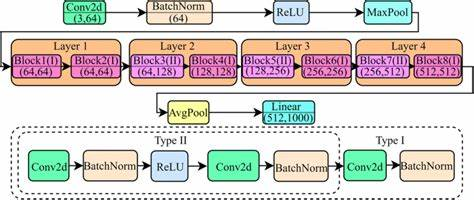

In [5]:

# The Basic Block (2 Convolutional Layers, Batch Normalization, ReLU Activation)
class BasicBlock (nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential() # This 
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out
    
# Now to implement the ResNet 18 Model
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

## Training Implementation

In [14]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# Before Training, check if GPU is available and set the device
device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Device: ",device)

Device:  cuda


Epoch 0 loss: 0.33222341018192697
Train Accuracy: 91.0952380952381
Epoch 1 loss: 0.15752818467885707
Train Accuracy: 96.14285714285714
Epoch 2 loss: 0.11730806444856254
Train Accuracy: 94.57142857142857
Epoch 3 loss: 0.11157525233416395
Train Accuracy: 97.66666666666667
Epoch 4 loss: 0.08252437177085967
Train Accuracy: 98.19047619047619
Epoch 5 loss: 0.07271460593663946
Train Accuracy: 97.69047619047619
Epoch 6 loss: 0.06943909078483668
Train Accuracy: 97.85714285714286
Epoch 7 loss: 0.0805848602498317
Train Accuracy: 98.71428571428571
Epoch 8 loss: 0.0717044626962337
Train Accuracy: 98.30952380952381
Epoch 9 loss: 0.058186055065810004
Train Accuracy: 98.54761904761905


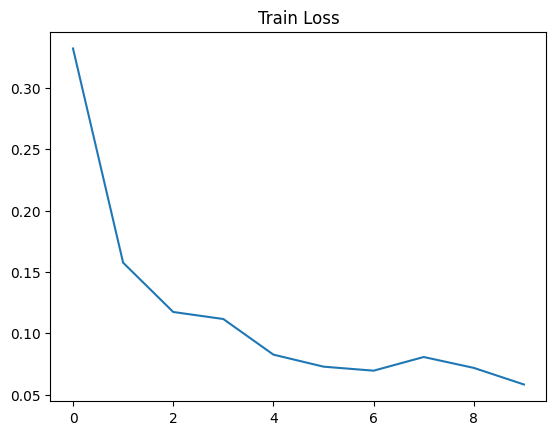

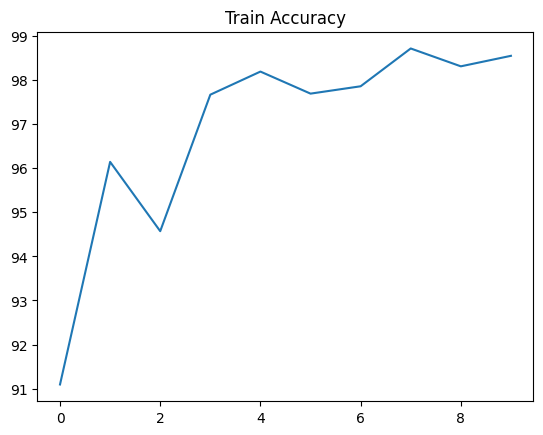

In [ ]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.001
momentum = 0.9

model = ResNet18()
criterion = nn.CrossEntropyLoss()
optimizer = th.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# Send data and model to device
model.to(device)
criterion.to(device)

# Graph loss and accuracy
losses = []
accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch} loss: {running_loss / len(train_loader)}')
    losses.append(running_loss / len(train_loader))
    # print train accuracy
    correct = 0
    total = 0
    with th.no_grad():
        for data in train_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = th.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Train Accuracy: {100 * correct / total}')
    accuracies.append(100 * correct / total)


# Save the model to a file
th.save(model.state_dict(), 'resnet18.pth')




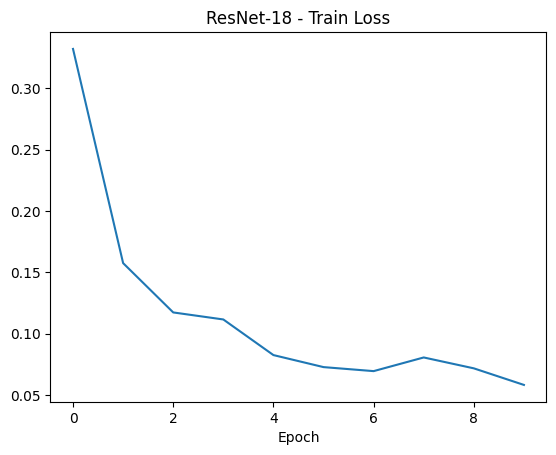

C:\Users\alvar\AppData\Local\Temp\ipykernel_8576\3895517648.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])


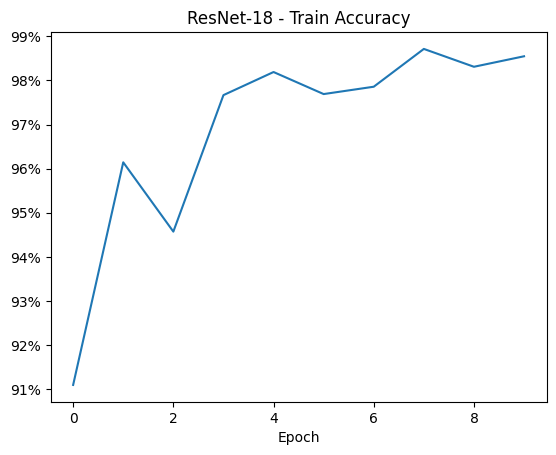

In [21]:
# Plot the loss and accuracy
plt.plot(losses)
plt.title('ResNet-18 - Train Loss')
# Print  the word epoch on x-axis
plt.xlabel('Epoch')

plt.show()

plt.plot(accuracies)
plt.title('ResNet-18 - Train Accuracy')
# Print epoch on x-axis
plt.xlabel('Epoch')
# Add percentage sign to y-axis
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
plt.show()

C:\Users\alvar\AppData\Local\Temp\ipykernel_8576\1443806178.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(th.load('resnet18.pth'))


Accuracy of the network on the test images: 98 %


<Figure size 640x480 with 0 Axes>

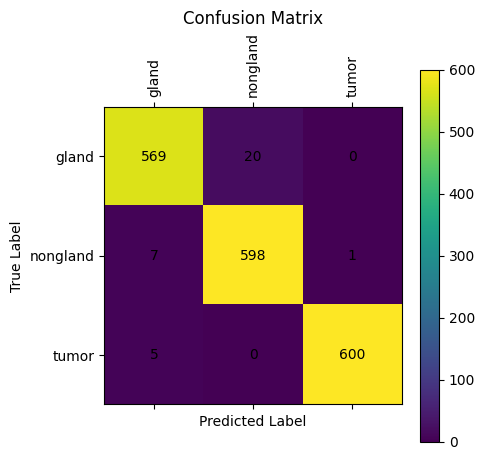

In [19]:
# Load the model from a file
model = ResNet18()
model.load_state_dict(th.load('resnet18.pth'))

# Set the model to evaluation mode
model.eval()

# Test the model to get Accuracy
correct = 0
total = 0

# Get the confusion matrix
confusion_matrix = np.zeros((len(dataset.classes), len(dataset.classes)))


with th.no_grad():
    for data in test_loader:
        images, labels = data[0], data[1]
        outputs = model(images)
        _, predicted = th.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Add the confusion matrix
        for i in range(len(predicted)):
            confusion_matrix[labels[i], predicted[i]] += 1

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

# Plot the confusion matrix
plt.figure()
plt.matshow(confusion_matrix)
plt.title('Confusion Matrix')
# add the numbers to the plot
for i in range(len(dataset.classes)):
    for j in range(len(dataset.classes)):
        plt.text(j, i, int(confusion_matrix[i, j]), ha='center', va='center')
plt.colorbar()
# Instead of 0, 1 ,2 add the class names
plt.xticks(range(len(dataset.classes)), dataset.classes, rotation=90)
plt.yticks(range(len(dataset.classes)), dataset.classes)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

